In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
from scipy.optimize import fsolve

from laser_generic import Model
from laser_generic.infection import Infection
from laser_generic.susceptibility import Susceptibility
from laser_generic.transmission import Transmission
from laser_generic.utils import seed_infections_randomly
from laser_generic.utils import set_initial_susceptibility_randomly

f"{np.__version__=}"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


"np.__version__='1.26.4'"

In [2]:
scenario = pd.DataFrame(data=[["homenode", 1e6, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])
parameters = PropertySet({"seed": 2, "nticks": 730, "verbose": True, "beta": 0.1, "inf_mean": 50})

2024-12-20 20:45:51.193622: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-20 20:45:51.199489: Running the generic model for 730 ticks…


100%|██████████| 730/730 [00:01<00:00, 504.84it/s]


Completed the generic model at 2024-12-20 20:45:52.665345…
Model         :         4,528 µs
Susceptibility:        42,853 µs
Transmission  :     1,042,905 µs
Infection     :       338,137 µs
Total:              1,428,423 microseconds


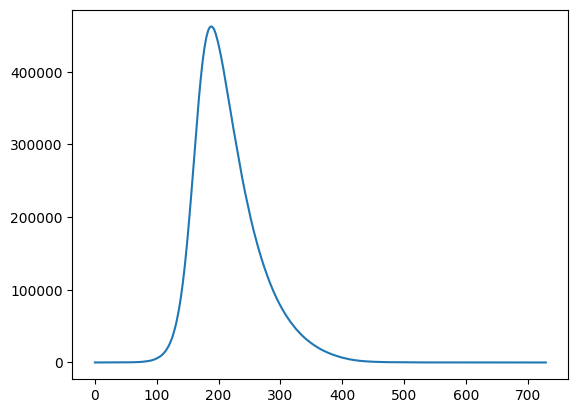

In [3]:
model = Model(scenario, parameters)
model.components = [
    Susceptibility,
    Transmission,
    Infection,
]

set_initial_susceptibility_randomly(model, 1.0)
seed_infections_randomly(model, ninfections=1)
model.run()
plt.plot(model.patches.cases)

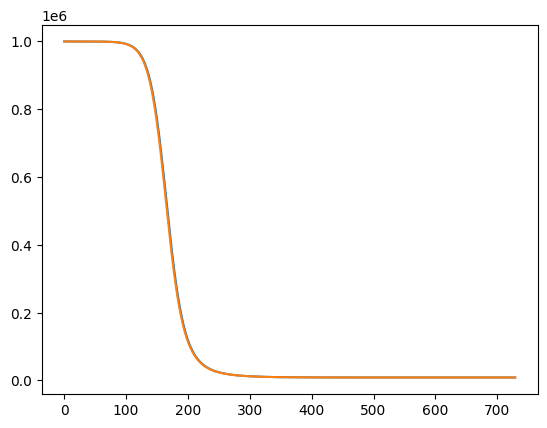

In [4]:
plt.plot(model.patches.susceptibility)
plt.plot(1e6 - np.cumsum(model.patches.incidence))

In [5]:
def KM_limit(z, R0, S0, I0):
    if R0 * S0 < 1:
        return 0
    else:
        return z - S0 * (1 - np.exp(-R0 * (z + I0)))


population = 1e5
# fsolve(KM_limit, 0, args=(3.0, 0.2, 0.0001))
R0s = np.concatenate((np.linspace(0.2, 1.0, 5), np.linspace(1.5, 10.0, 25)))
S0s = [1.0, 0.8, 0.6, 0.4, 0.2]
output = pd.DataFrame(list(itertools.product(R0s, S0s)), columns=["R0", "S0"])
output["I_inf_exp"] = [
    fsolve(KM_limit, 0.5 * (R0 * S0 >= 1), args=(R0, S0, 20 / population))[0] for R0, S0 in zip(output["R0"], output["S0"])
]
output["S_inf_exp"] = output["S0"] - output["I_inf_exp"]
output["I_inf_obs"] = np.nan
output["S_inf_obs"] = np.nan

In [6]:
%%capture

inf_mean = 20
for index, row in output.iterrows():
    scenario = pd.DataFrame(data=[["homenode", population, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])
    parameters = PropertySet({"seed": 2, "nticks": 730, "verbose": True, "inf_mean": inf_mean, "beta": row["R0"] / inf_mean})

    model = Model(scenario, parameters)
    model.components = [
        Susceptibility,
        Transmission,
        Infection,
    ]

    set_initial_susceptibility_randomly(model, row["S0"])
    seed_infections_randomly(model, ninfections=20)
    model.run()

    output.loc[index, "I_inf_obs"] = np.sum(model.patches.incidence) / population
    output.loc[index, "S_inf_obs"] = model.patches.susceptibility[-1] / population


# for R0 in R0s:
#     for S0 in S0s:
#         expected =

In [7]:
output

,R0,S0,I_inf_exp,S_inf_exp,I_inf_obs,S_inf_obs
0,0.2,1.0,0.000000,1.000000,0.00004,0.99976
1,0.2,0.8,0.000000,0.800000,0.00004,0.79977
2,0.2,0.6,0.000000,0.600000,0.00003,0.59977
3,0.2,0.4,0.000000,0.400000,0.00002,0.39978
4,0.2,0.2,0.000000,0.200000,0.00002,0.19978
...,...,...,...,...,...,...
145,10.0,1.0,0.999955,0.000045,0.99972,0.00008
146,10.0,0.8,0.799731,0.000269,0.79951,0.00030
147,10.0,0.6,0.598493,0.001507,0.59807,0.00173
148,10.0,0.4,0.392086,0.007914,0.39072,0.00908


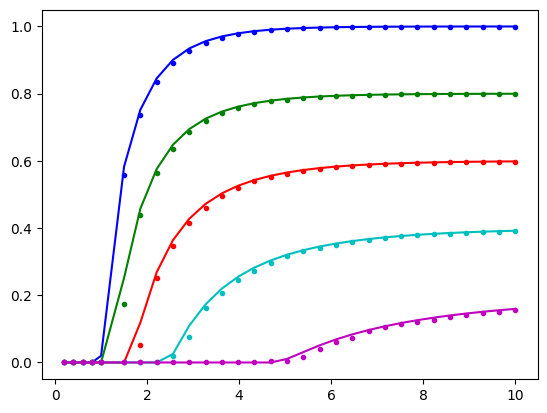

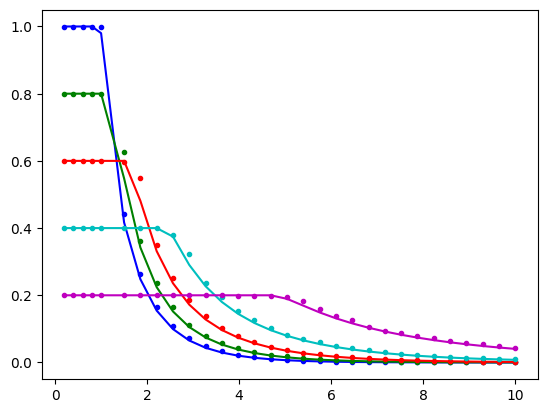

Bad pipe message: %s [b'=\xfb\xdb\xab\xa0\x08/,\xa22\xfbb\xd6\xd1\xbc6+F\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00', b"\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\x16\xc0\x17\xc0\x18\xc0\x19\xc0#\xc0$\xc0%\xc0&\xc0'\x

In [8]:
colors = itertools.cycle(["b", "g", "r", "c", "m", "y", "k"])
for S0 in S0s:
    condition = output["S0"] == S0
    color = next(colors)
    plt.plot(output[condition]["R0"], output[condition]["I_inf_exp"], label=f"Expected S0={S0}", color=color)
    plt.plot(output[condition]["R0"], output[condition]["I_inf_obs"], ".", label=f"Observed S0={S0}", color=color)
plt.figure()
colors = itertools.cycle(["b", "g", "r", "c", "m", "y", "k"])
for S0 in S0s:
    condition = output["S0"] == S0
    color = next(colors)

    plt.plot(output[condition]["R0"], output[condition]["S_inf_exp"], label=f"Expected S0={S0}", color=color)
    plt.plot(output[condition]["R0"], output[condition]["S_inf_obs"], ".", label=f"Observed S0={S0}", color=color)
# condition = output['S0'] == 1.0
# plt.plot(output[condition]['R0'], output[condition]['I_inf_exp'], label='Expected')
# plt.plot(output[condition]['R0'], output[condition]['I_inf_obs'], '.', label='Observed')

In [6]:
np.random.exponential(1 / (50 / 365 / 1000), 10)

array([16281.11655109,  3584.21707715,  7170.77377301,  5566.01033623,
        3106.52167692,  6429.95493347,  3483.72935794,   308.61376256,
       18790.33897488, 12446.34708649])